# Filtering and Hybrid Images

### Om Shri Prasath EE17B113

## Importing the required libraries

- Numpy - For matrix manipulations (mainly used in Non-Max Supression and Calculating Magnitude and Angle)
- Scipy - For generating Gaussian Kernel and Convolutions
- Matplotlib - For displaying image
- OpenCV - For reading images from source

In [1]:
# Importing the required libraries

import numpy as np
import scipy.stats as st
import scipy.signal as sg
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import cv2

# To remove unnecessary warnings
import warnings

warnings.filterwarnings("ignore")

# Note : Used for autoformatting the notebook, remove if causing any error
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Parameters for good matplotlib output

plt.rcParams["figure.autolayout"] = False
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.size"] = 16
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.markersize"] = 6
plt.rcParams["legend.fontsize"] = 18
plt.rcParams["legend.numpoints"] = 2
plt.rcParams["legend.loc"] = "best"
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.shadow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "cm"
plt.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}", r"\usepackage{amssymb}"]

<IPython.core.display.Javascript object>

## Filtering on 1-D Array

Creating the signal generator using numpy

In [3]:
# Function to generate signal X given range k
def x(k):
    x = np.zeros(k.shape)
    x[(k > -1) & (k < 16)] = 3 + np.sin(2 * k[(k > -1) & (k < 16)] * np.pi / 15)
    return x

<IPython.core.display.Javascript object>

Plotting the signal

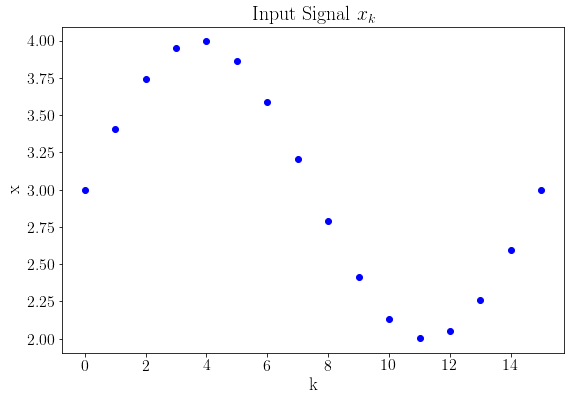

<IPython.core.display.Javascript object>

In [4]:
# Creating the signal range
k = np.arange(0, 16)

# Generating the signal and plotting it

plt.title(r"Input Signal $x_k$")
plt.plot(k, x(k), "bo")
plt.xlabel("k")
plt.ylabel("x")
plt.show()

#### Creating filter 1 : $y_k = x_{k+1}-x_k$

In [5]:
def y_1(k):
    return x(k + 1) - x(k)

<IPython.core.display.Javascript object>

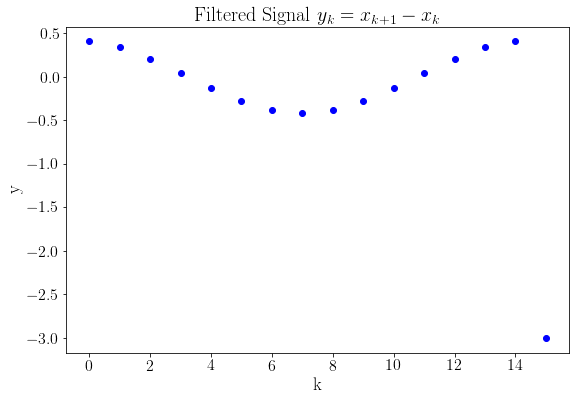

<IPython.core.display.Javascript object>

In [6]:
plt.title(r"Filtered Signal $y_k = x_{k+1}-x_k$")
plt.plot(k, y_1(k), "bo")
plt.xlabel("k")
plt.ylabel("y")
plt.show()

#### Creating filter 2 : $y_k = x_{k}-\bar{X}$ where $\bar{X} = \dfrac{1}{L+1}\sum\limits_{i=0}^{L}x_i$

In [7]:
def y_2(k):
    return x(k) - np.average(x(k))

<IPython.core.display.Javascript object>

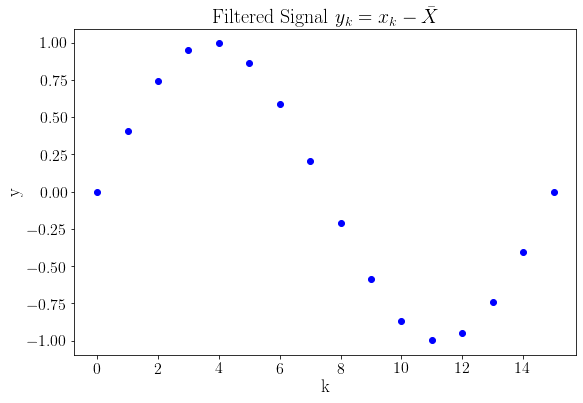

<IPython.core.display.Javascript object>

In [8]:
plt.title(r"Filtered Signal $y_k = x_{k}-\bar{X}$")
plt.plot(k, y_2(k), "bo")
plt.xlabel("k")
plt.ylabel("y")
plt.show()

#### Creating filter 3 : $y_k = median(\{x_l : l \in [k-2,k+2]\})$

In [9]:
def y_3(k):
    return np.array([np.median(x(np.arange(l - 2, l + 3))) for l in k])

<IPython.core.display.Javascript object>

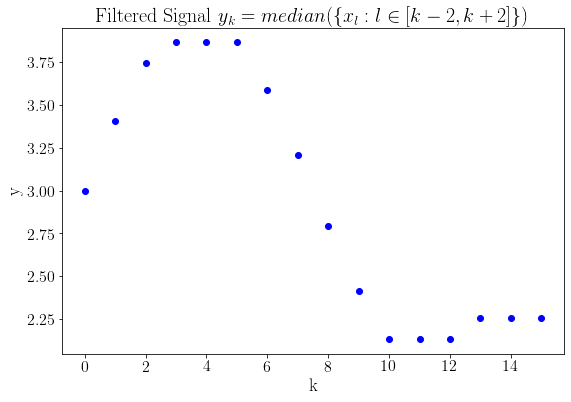

<IPython.core.display.Javascript object>

In [10]:
plt.title(r"Filtered Signal $y_k = median(\{x_l : l \in [k-2,k+2]\})$")
plt.plot(k, y_3(k), "bo")
plt.xlabel("k")
plt.ylabel("y")
plt.show()

#### Creating filter 4 : $y_k = x_{k+0.5}-x_{k-0.5}$

Using linear interpolation : 

$x_{k+0.5} = x_{k}+\dfrac{(x_{k+1} - x_{k})}{2} = \dfrac{x_{k+1}+x_{k}}{2} \implies$ The values at the middle (0.5) are just the averages of the nearby points.

$\implies y_k = \dfrac{x_{k}+x_{k+1} - x_{k}-x_{k-1}}{2} = \dfrac{x_{k+1}-x_{k-1}}{2}$

In [11]:
def y_4(k):
    return (x(k + 1) - x(k - 1)) / 2

<IPython.core.display.Javascript object>

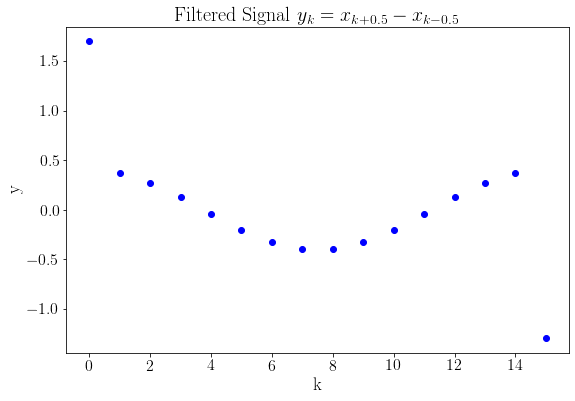

<IPython.core.display.Javascript object>

In [12]:
plt.title(r"Filtered Signal $y_k = x_{k+0.5}-x_{k-0.5}$")
plt.plot(k, y_4(k), "bo")
plt.xlabel("k")
plt.ylabel("y")
plt.show()

#### Creating filter 5 : $y_k = |x_{k+0.5}-x_{k-0.5}|$

(We use the same transform as above)

In [13]:
def y_5(k):
    return np.abs((x(k + 1) - x(k - 1)) / 2)

<IPython.core.display.Javascript object>

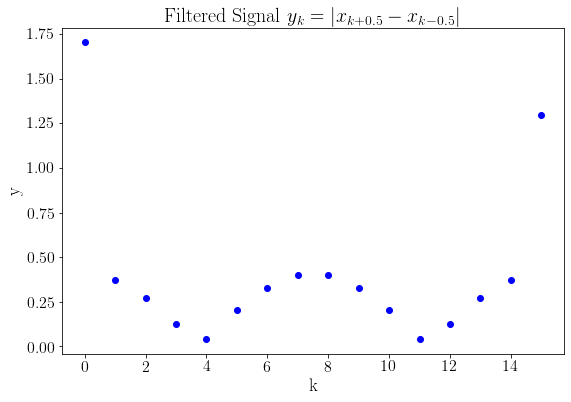

<IPython.core.display.Javascript object>

In [14]:
plt.title(r"Filtered Signal $y_k = |x_{k+0.5}-x_{k-0.5}|$")
plt.plot(k, y_5(k), "bo")
plt.xlabel("k")
plt.ylabel("y")
plt.show()

#### Creating filter 6 : $y_k = \dfrac{1}{5}\sum\limits_{i=k-2}^{k+2} x_i$

In [15]:
def y_6(k):
    return np.array([np.sum(x(np.arange(l - 2, l + 3))) / 5 for l in k])

<IPython.core.display.Javascript object>

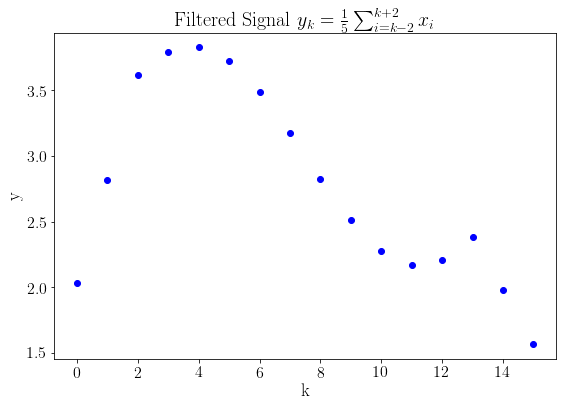

<IPython.core.display.Javascript object>

In [16]:
plt.title(r"Filtered Signal $y_k = \frac{1}{5}\sum_{i=k-2}^{k+2} x_i$")

plt.plot(k, y_6(k), "bo")
plt.xlabel("k")
plt.ylabel("y")
plt.show()

### The filters which are LTI are $y_1, y_4$ and $y_6$ only. Other filters do not satisfy the conditions to be LTI.

Defining function to do convolution

In [17]:
def convolve_1d(x, h):
    if x.shape[0] < h.shape[0]:
        temp = x
        x = h
        h = temp

    x_padded = np.hstack([np.zeros((len(h) // 2,)), x, np.zeros((len(h) // 2,))])
    h = h[::-1]
    y = []

    for i in range(len(x)):
        f = 0
        for k in range(len(h)):
            f += x_padded[i + k] * h[k]
        y.append(f)

    return np.array(y)

<IPython.core.display.Javascript object>

The convolutional filter for $y_1 \to h_1 = \begin{bmatrix}1 & -1 & 0\end{bmatrix}$

In [18]:
h_1 = np.array([1, -1, 0])

<IPython.core.display.Javascript object>

The convolutional filter for $y_4 \to h_4 = \begin{bmatrix}0.5 & 0 & -0.5\end{bmatrix}$

In [19]:
h_4 = np.array([0.5, 0, -0.5])

<IPython.core.display.Javascript object>

The convolutional filter for $y_6 \to h_6 = \begin{bmatrix}0.2 & 0.2 & 0.2 & 0.2 & 0.2\end{bmatrix}$

In [20]:
h_6 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

<IPython.core.display.Javascript object>

Applying the filter $h_1$ and visualizing the output and comparing with direct computation

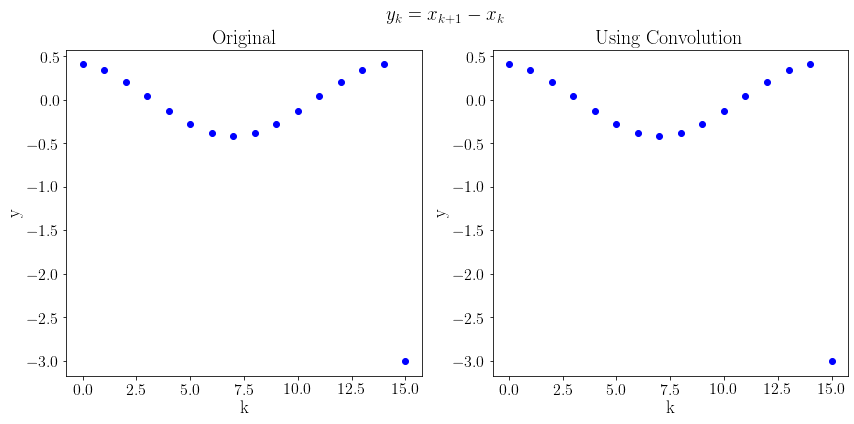

<IPython.core.display.Javascript object>

In [21]:
y_1_c = convolve_1d(x(k), h_1)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle(r"$y_k = x_{k+1}-x_k$")
axs[0].plot(k, y_1(k), "bo")
axs[0].set_title("Original")
axs[0].set_xlabel("k")
axs[0].set_ylabel("y")

axs[1].plot(k, y_1_c, "bo")
axs[1].set_title("Using Convolution")
axs[1].set_xlabel("k")
axs[1].set_ylabel("y")

plt.show()

Applying the filter $h_4$ and visualizing the output and comparing with direct computation

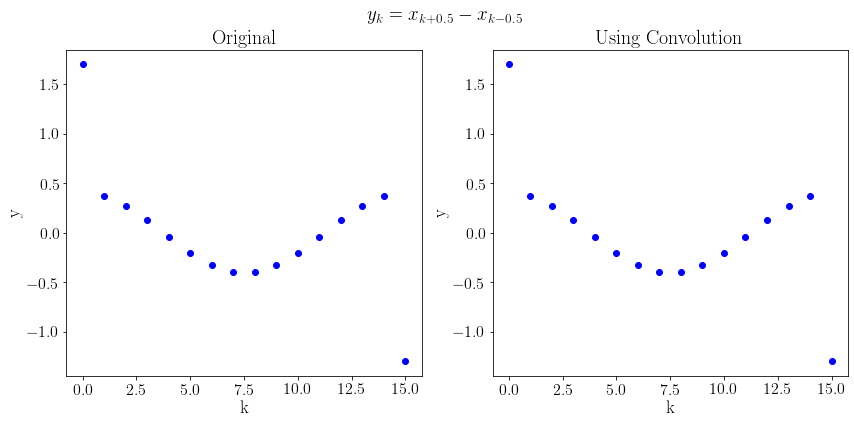

<IPython.core.display.Javascript object>

In [22]:
y_4_c = convolve_1d(x(k), h_4)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle(r"$y_k = x_{k+0.5}-x_{k-0.5}$")
axs[0].plot(k, y_4(k), "bo")
axs[0].set_title("Original")
axs[0].set_xlabel("k")
axs[0].set_ylabel("y")

axs[1].plot(k, y_4_c, "bo")
axs[1].set_title("Using Convolution")
axs[1].set_xlabel("k")
axs[1].set_ylabel("y")

plt.show()

Applying the filter $h_6$ and visualizing the output and comparing with direct computation

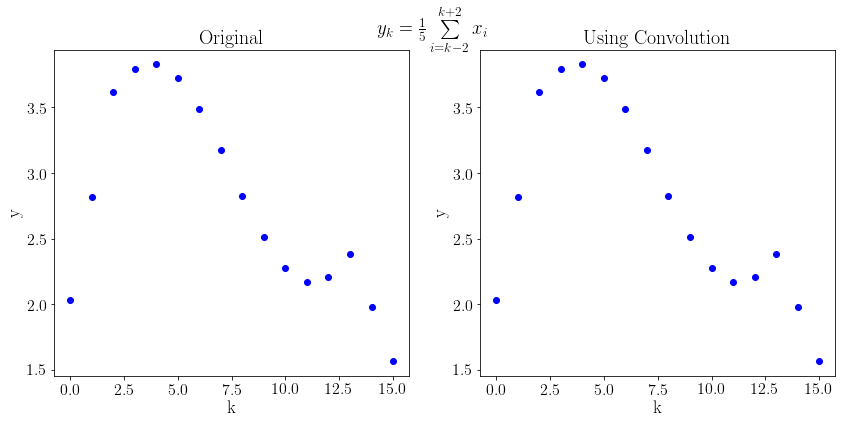

<IPython.core.display.Javascript object>

In [23]:
y_6_c = convolve_1d(x(k), h_6)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle(r"$y_k = \frac{1}{5}\sum\limits_{i=k-2}^{k+2} x_i$")
axs[0].plot(k, y_6(k), "bo")
axs[0].set_title("Original")
axs[0].set_xlabel("k")
axs[0].set_ylabel("y")

axs[1].plot(k, y_6_c, "bo")
axs[1].set_title("Using Convolution")
axs[1].set_xlabel("k")
axs[1].set_ylabel("y")

plt.show()

## Convolution using Fourier Transform

We will try to transform the convolution in space domain into multiplication in frequency domain and transform back to time domain to check the output.

Computing the convolution using multiplication in frequency domain for $h_1$ and visualizing the output

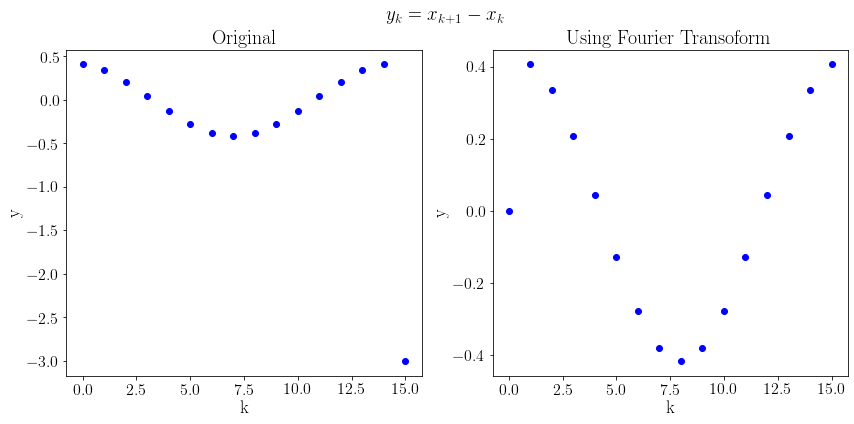

<IPython.core.display.Javascript object>

In [30]:
y_1_ft = np.fft.ifft(
    np.fft.fft(np.concatenate([h_1, np.zeros(len(k) - len(h_1))])) * np.fft.fft(x(k))
)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle(r"$y_k = x_{k+1}-x_k$")
axs[0].plot(k, y_1(k), "bo")
axs[0].set_title("Original")
axs[0].set_xlabel("k")
axs[0].set_ylabel("y")

axs[1].plot(k, y_1_ft, "bo")
axs[1].set_title("Using Fourier Transoform")
axs[1].set_xlabel("k")
axs[1].set_ylabel("y")

plt.show()

Computing the convolution using multiplication in frequency domain for $h_4$ and visualizing the output

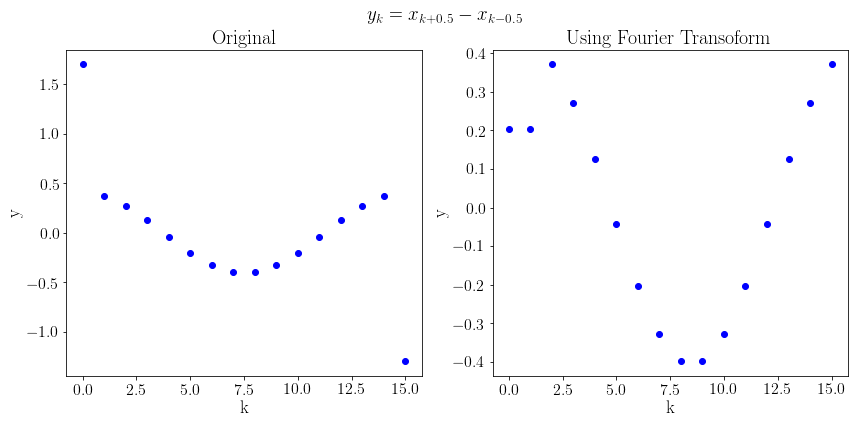

<IPython.core.display.Javascript object>

In [31]:
y_4_ft = np.fft.ifft(
    np.fft.fft(np.concatenate([h_4, np.zeros(len(k) - len(h_4))])) * np.fft.fft(x(k))
)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle(r"$y_k = x_{k+0.5}-x_{k-0.5}$")
axs[0].plot(k, y_4(k), "bo")
axs[0].set_title("Original")
axs[0].set_xlabel("k")
axs[0].set_ylabel("y")

axs[1].plot(k, y_4_ft, "bo")
axs[1].set_title("Using Fourier Transoform")
axs[1].set_xlabel("k")
axs[1].set_ylabel("y")

plt.show()

Computing the convolution using multiplication in frequency domain for $h_6$ and visualizing the output

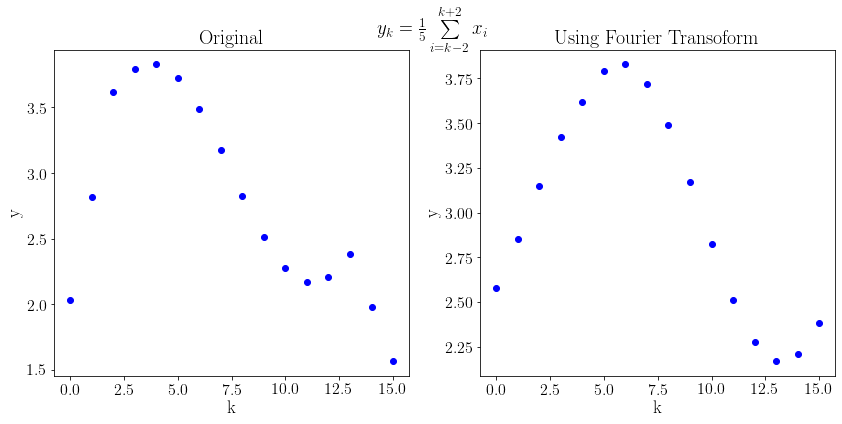

<IPython.core.display.Javascript object>

In [32]:
y_6_ft = np.fft.ifft(
    np.fft.fft(np.concatenate([h_6, np.zeros(len(k) - len(h_6))])) * np.fft.fft(x(k))
)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle(r"$y_k = \frac{1}{5}\sum\limits_{i=k-2}^{k+2} x_i$")
axs[0].plot(k, y_6(k), "bo")
axs[0].set_title("Original")
axs[0].set_xlabel("k")
axs[0].set_ylabel("y")

axs[1].plot(k, y_6_ft, "bo")
axs[1].set_title("Using Fourier Transoform")
axs[1].set_xlabel("k")
axs[1].set_ylabel("y")

plt.show()

We see that none of the above outputs from Fourier Transform match the output of applying the filter. This is because the multiplication in frequency domain does not match directly the _linear convolution_ in space domain, rather it matches _circular convolution_ in space domain. To get normal _linear convolution_ from _circular convolution_, we need to first pad the input signal by half the length of the filter signal on both sides, then multiply the Fourier Transforms of the signals and then clip out the starting part of the output which is not required to get the required output.

In [50]:
# Function to do linear convolution using fourier transform outputs
def fft_convolve_1d(x, h):
    x_padded = np.hstack([np.zeros(len(h) // 2,), x, np.zeros(len(h) // 2,)])
    y = np.fft.ifft(
        np.fft.fft(np.concatenate([h, np.zeros(len(x_padded) - len(h))]))
        * np.fft.fft(x_padded)
    )[(len(h) // 2) * 2 :]

    return y

<IPython.core.display.Javascript object>

Applying the modified convolution using Fourier Transform and visualizing the output for $h_1$

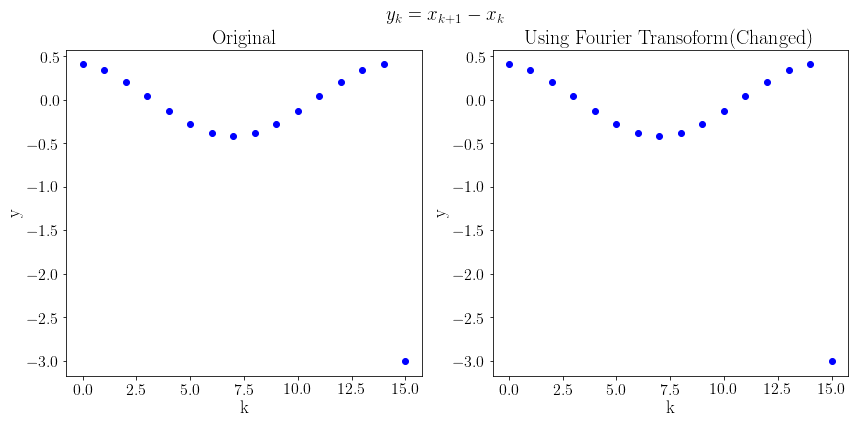

<IPython.core.display.Javascript object>

In [51]:
y_1_fft_con = fft_convolve_1d(x(k), h_1)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle(r"$y_k = x_{k+1}-x_k$")
axs[0].plot(k, y_1(k), "bo")
axs[0].set_title("Original")
axs[0].set_xlabel("k")
axs[0].set_ylabel("y")

axs[1].plot(k, y_1_fft_con, "bo")
axs[1].set_title("Using Fourier Transoform(Changed)")
axs[1].set_xlabel("k")
axs[1].set_ylabel("y")

plt.show()

Applying the modified convolution using Fourier Transform and visualizing the output for $h_4$

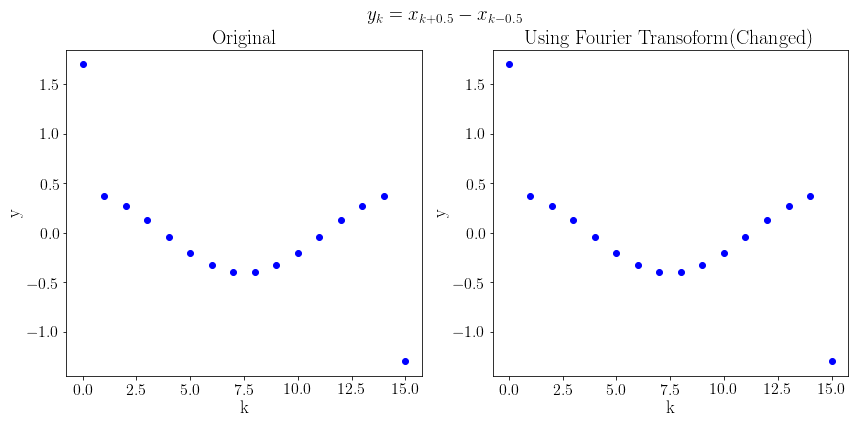

<IPython.core.display.Javascript object>

In [52]:
y_4_fft_con = fft_convolve_1d(x(k), h_4)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle(r"$y_k = x_{k+0.5}-x_{k-0.5}$")
axs[0].plot(k, y_4(k), "bo")
axs[0].set_title("Original")
axs[0].set_xlabel("k")
axs[0].set_ylabel("y")

axs[1].plot(k, y_4_fft_con, "bo")
axs[1].set_title("Using Fourier Transoform(Changed)")
axs[1].set_xlabel("k")
axs[1].set_ylabel("y")

plt.show()

Applying the modified convolution using Fourier Transform and visualizing the output for $h_6$

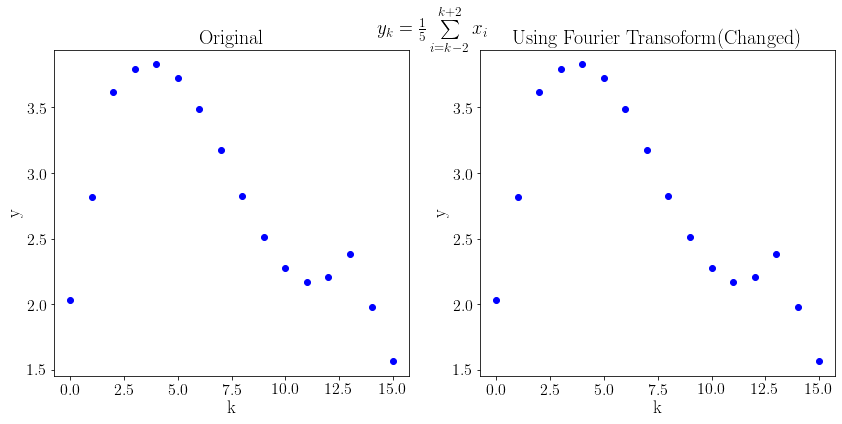

<IPython.core.display.Javascript object>

In [53]:
y_6_fft_con = fft_convolve_1d(x(k), h_6)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle(r"$y_k = \frac{1}{5}\sum\limits_{i=k-2}^{k+2} x_i$")
axs[0].plot(k, y_6(k), "bo")
axs[0].set_title("Original")
axs[0].set_xlabel("k")
axs[0].set_ylabel("y")

axs[1].plot(k, y_6_fft_con, "bo")
axs[1].set_title("Using Fourier Transoform(Changed)")
axs[1].set_xlabel("k")
axs[1].set_ylabel("y")

plt.show()

## Hybrid Images

We have created the function to filter the image in `my_filter.py`. We will import the functions from it and use it now

In [60]:
from helpers import load_image, save_image, vis_hybrid_image

<IPython.core.display.Javascript object>

Function to convolve an image with a given filter

In [58]:
def filter_image(img, fil):

    # Checking for correctness of filter
    if fil.shape[0] != fil.shape[1] or fil.shape[0] % 2 == 0 or fil.shape[1] % 2 == 0:
        raise Exception("Please enter correct filter")

    # Applying filter on color image
    if len(img.shape) != 2 and img.shape[2] == 3:
        out = []
        for i in range(3):
            out.append(sg.convolve2d(img[:, :, i], fil, mode="same", boundary="symm"))
        return np.dstack(out)
    # Appying filter on grayscale image
    else:
        return sg.convolve2d(img, fil, mode="same", boundary="symm")

<IPython.core.display.Javascript object>

Function to create a gaussian kernel

In [59]:
def gaussian_kernel(sig):

    # Creating kernel size for given sigma value

    if (int(6 * sig) + 1) % 2 == 0:
        kern = int(6 * sig)
    else:
        kern = int(6 * sig) + 1

    # Creating an 1d Space
    x = np.linspace(-2 / sig, 2 / sig, kern)

    # Generating 1d Gaussian Kernel by taking the difference of CDF of the above space
    gauss_1d = st.norm.pdf(x)

    # Creating the 2d Gaussian Kernel by multiplying two 1d Gaussian Kernels
    gauss_2d = np.outer(gauss_1d, gauss_1d)

    # Normalizing the Gaussian Kernel
    gauss_kernel = gauss_2d / gauss_2d.sum()

    return gauss_kernel

<IPython.core.display.Javascript object>

__We will define functions to create the hybrid filters :__

- `low_pass` : Gives the low-pass filtered output of image.
- `high_pass` : Gives the high-pass filtered output of image.
- `hybrid_image` : Combines the above two functions to create the hybrid image.

In [55]:
def low_pass(img, freq):
    kernel = gaussian_kernel(freq)
    out = filter_image(img, kernel)

    out = out / out.max()
    out[out < 0] = 0
    out[out > 1] = 1

    return out


def high_pass(img, freq):
    kernel = gaussian_kernel(freq)
    out = img - filter_image(img, kernel)

    out = out / out.max() + 0.5
    out[out < 0] = 0
    out[out > 1] = 1

    return out


def hybrid_image(img1, img2, freq1, freq2):
    img_low = low_pass(img1, freq1)
    img_high = high_pass(img2, freq2)

    return (img_low + img_high) / 2

<IPython.core.display.Javascript object>

**Bicycle and Motorcycle**

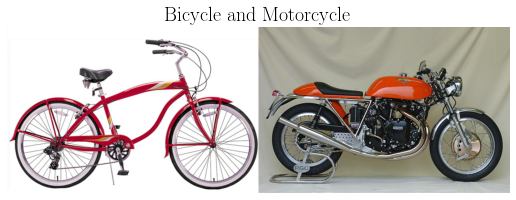

<IPython.core.display.Javascript object>

In [38]:
img1 = load_image("data/ex01/bicycle.bmp")
img2 = load_image("data/ex01/motorcycle.bmp")

plt.title("Bicycle and Motorcycle")
plt.imshow(np.hstack([img1, img2]))
plt.axis("off")
plt.show()

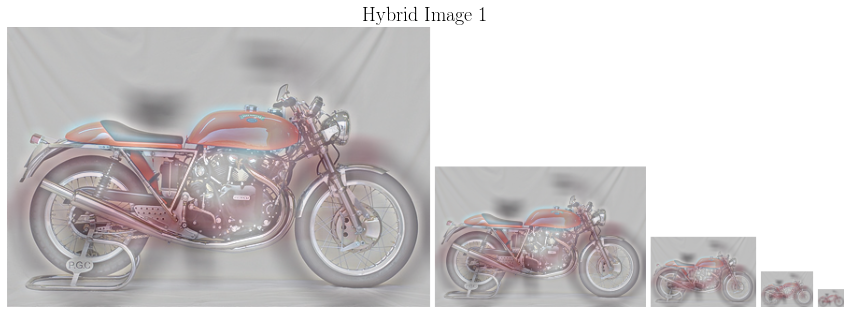

<IPython.core.display.Javascript object>

In [39]:
img_hyb = hybrid_image(img1, img2, 5, 3)

plt.figure(figsize=(15, 10))

plt.title("Hybrid Image 1")
plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

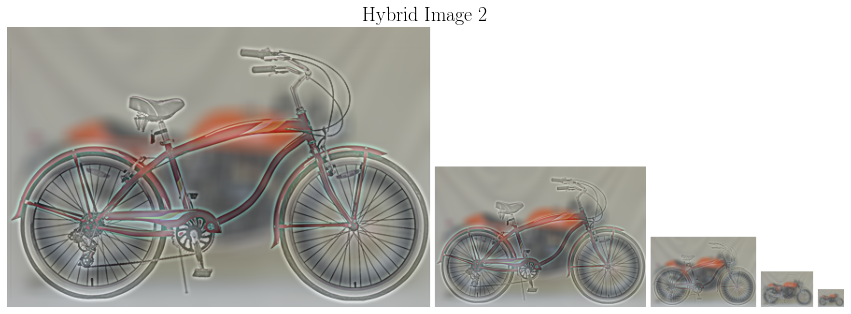

<IPython.core.display.Javascript object>

In [40]:
img_hyb = hybrid_image(img2, img1, 3, 1.5)

plt.figure(figsize=(15, 10))

plt.title("Hybrid Image 2")
plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

**Bird and Plane**

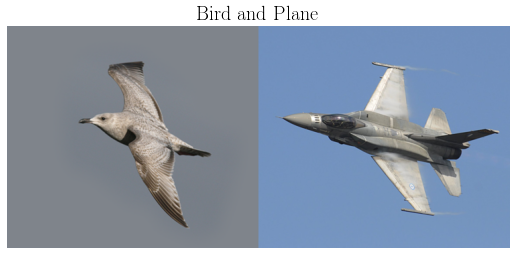

<IPython.core.display.Javascript object>

In [41]:
img1 = load_image("data/ex02/bird.bmp")
img2 = load_image("data/ex02/plane.bmp")

plt.title("Bird and Plane")
plt.imshow(np.hstack([img1, img2]))
plt.axis("off")
plt.show()

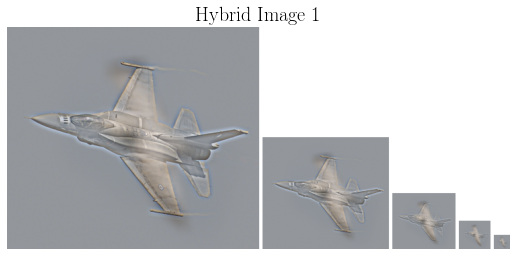

<IPython.core.display.Javascript object>

In [42]:
img_hyb = hybrid_image(img1, img2, 4, 2)

plt.title("Hybrid Image 1")
plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

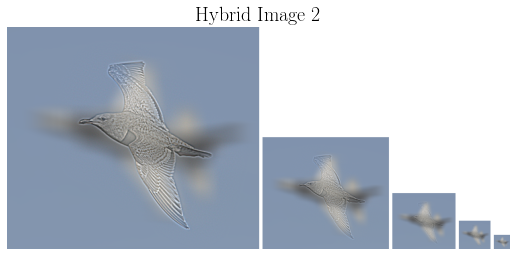

<IPython.core.display.Javascript object>

In [43]:
img_hyb = hybrid_image(img2, img1, 5, 1)

plt.title("Hybrid Image 2")
plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

**Cat and Dog**

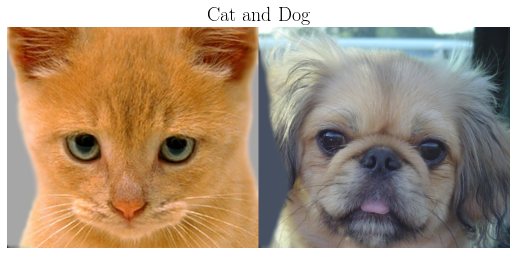

<IPython.core.display.Javascript object>

In [44]:
img1 = load_image("data/ex03/cat.bmp")
img2 = load_image("data/ex03/dog.bmp")

plt.title("Cat and Dog")
plt.imshow(np.hstack([img1, img2]))
plt.axis("off")
plt.show()

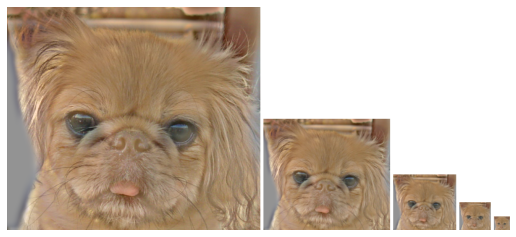

<IPython.core.display.Javascript object>

In [45]:
img_hyb = hybrid_image(img1, img2, 3, 4)

plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

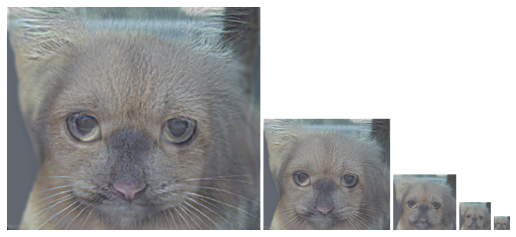

<IPython.core.display.Javascript object>

In [46]:
img_hyb = hybrid_image(img2, img1, 1.5, 2)

plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

**Einstein and Marilyn**

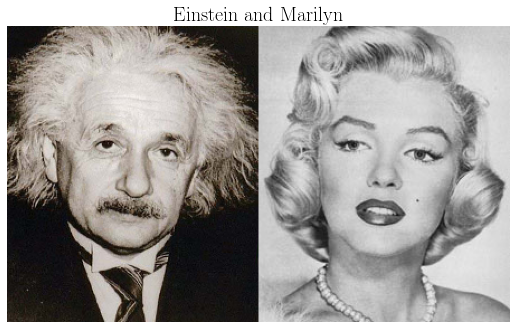

<IPython.core.display.Javascript object>

In [47]:
img1 = load_image("data/ex04/einstein.bmp")
img2 = load_image("data/ex04/marilyn.bmp")
plt.title("Einstein and Marilyn")
plt.imshow(np.hstack([img1, img2]))
plt.axis("off")
plt.show()

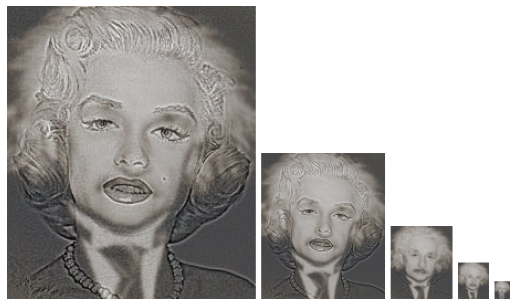

<IPython.core.display.Javascript object>

In [48]:
img_hyb = hybrid_image(img1, img2, 1, 1)

plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

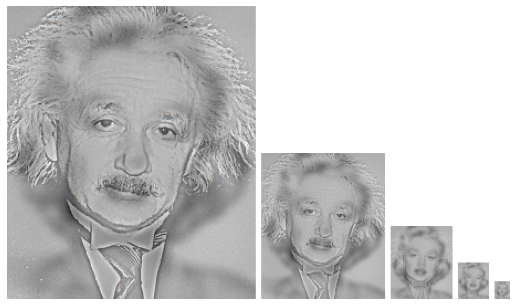

<IPython.core.display.Javascript object>

In [49]:
img_hyb = hybrid_image(img2, img1, 2, 1.5)

plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

**Fish and Submarine**

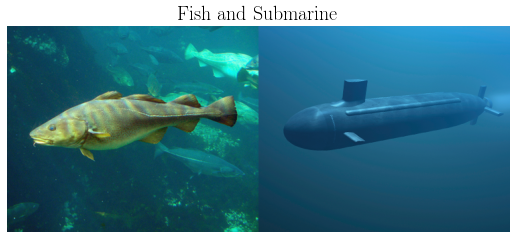

<IPython.core.display.Javascript object>

In [50]:
img1 = load_image("data/ex05/fish.bmp")
img2 = load_image("data/ex05/submarine.bmp")

plt.title("Fish and Submarine")
plt.imshow(np.hstack([img1, img2]))
plt.axis("off")
plt.show()

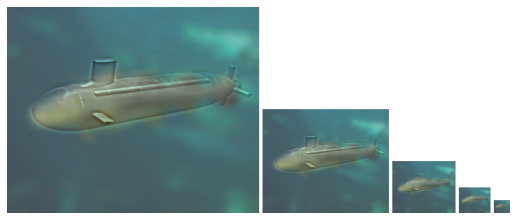

<IPython.core.display.Javascript object>

In [51]:
img_hyb = hybrid_image(img1, img2, 3, 2)

plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

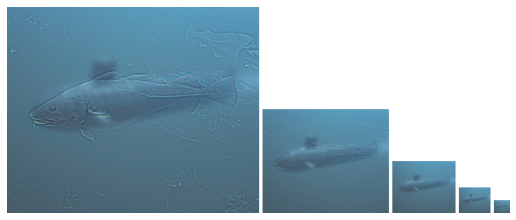

<IPython.core.display.Javascript object>

In [52]:
img_hyb = hybrid_image(img2, img1, 2, 1)

plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

**Durian and Ukulele**

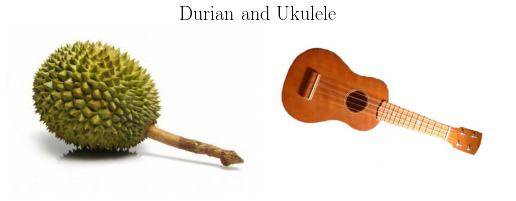

<IPython.core.display.Javascript object>

In [55]:
img1 = load_image("data/ex06/durian.jpg")
img2 = load_image("data/ex06/ukulele.jpg")

# Preprocessing the ukulele to create hybrid image

# Rotating the image and resizing to durian shape
img2 = cv2.resize(
    nd.rotate(img2, -110, mode="constant", cval=1), (img1.shape[1], img1.shape[0]),
)

img2[img2 < 0] = 0
img2[img2 > 1] = 1

plt.imshow(img2.astype(np.uint8))
plt.title("Durian and Ukulele")
plt.imshow(np.hstack([img1, img2]))
plt.axis("off")
plt.show()

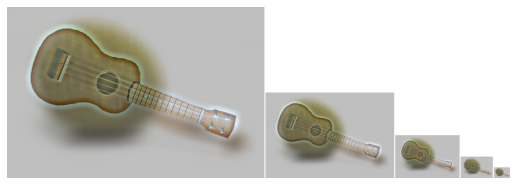

<IPython.core.display.Javascript object>

In [56]:
img_hyb = hybrid_image(img1, img2, 13, 9)

plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

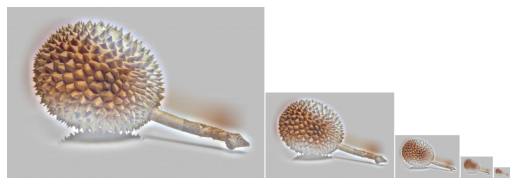

<IPython.core.display.Javascript object>

In [57]:
img_hyb = hybrid_image(img2, img1, 20, 10)

plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

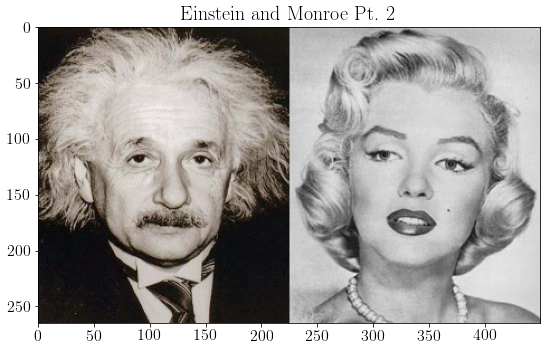

<IPython.core.display.Javascript object>

In [58]:
img1 = load_image("data/ex07/einstein.jpg")[10:-40, 25:-25, :]
img2 = load_image("data/ex07/marilyn.jpg")[:-35, :, :]

img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))
plt.title("Einstein and Monroe Pt. 2")
plt.imshow(np.hstack([img1, img2]))
plt.show()

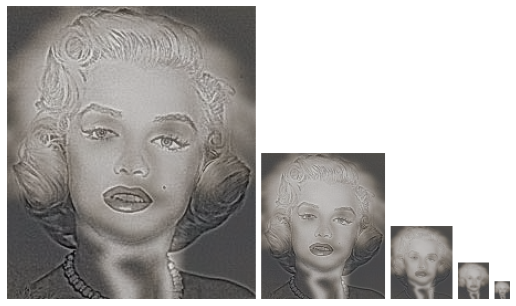

<IPython.core.display.Javascript object>

In [59]:
img_hyb = hybrid_image(img1, img2, 2, 1)

plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()

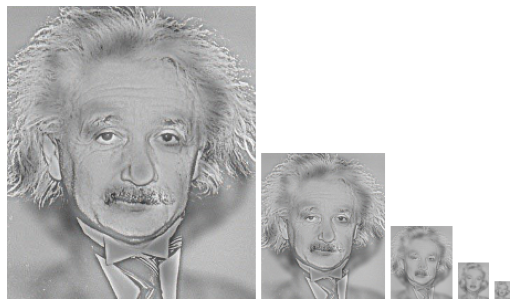

<IPython.core.display.Javascript object>

In [60]:
img_hyb = hybrid_image(img2, img1, 2, 1.5)

plt.imshow(vis_hybrid_image(img_hyb))
plt.axis("off")
plt.show()